In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Set plot style
sns.set(style="ticks", context="talk")
plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Make plots higher resolution

## Introduction: Bayesian Inference on Global Temperature Anomalies using MCMC

In this notebook, I explored Bayesian inference using the Metropolis-Hastings Markov Chain Monte Carlo (MCMC) algorithm. To demonstrate its application on a meaningful real-world problem, I chose to analyze the trend in global temperature anomalies over time. I obtained publicly available data, defined a simple linear model, specified priors, and implemented the MCMC algorithm from scratch to estimate the model parameters.

## 1. Data Loading and Exploration

First, I loaded the annual global temperature anomaly data. This data typically represents the deviation of the global average temperature from a baseline period (e.g., 1951-1980). I sourced this data from a publicly available CSV file derived from NASA's GISS Surface Temperature Analysis (GISTEMP v4).

*(Self-note: You'll need to download the appropriate CSV file - e.g., from DataHub: https://datahub.io/core/global-temp#data or NASA GISS: https://data.giss.nasa.gov/gistemp/ - and place it in the working directory or provide the correct path/URL.)*

Data loaded and cleaned successfully.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 1 to 74
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      67 non-null     int32  
 1   AnomalyC  67 non-null     float64
dtypes: float64(1), int32(1)
memory usage: 1.3 KB

Summary Statistics:
              Year   AnomalyC
count    67.000000  67.000000
mean   2013.328358   0.067985
std       6.497991   0.173059
min    2002.000000  -0.185000
25%    2008.000000  -0.062500
50%    2013.000000   0.030000
75%    2019.000000   0.190500
max    2024.000000   0.567000

    Year  AnomalyC
1   2003    -0.134
2   2004    -0.181
3   2005    -0.021
4   2006    -0.080
5   2007    -0.063
..   ...       ...
70  2020     0.290
71  2021     0.129
72  2022     0.174
73  2023     0.455
74  2024     0.567

[66 rows x 2 columns]


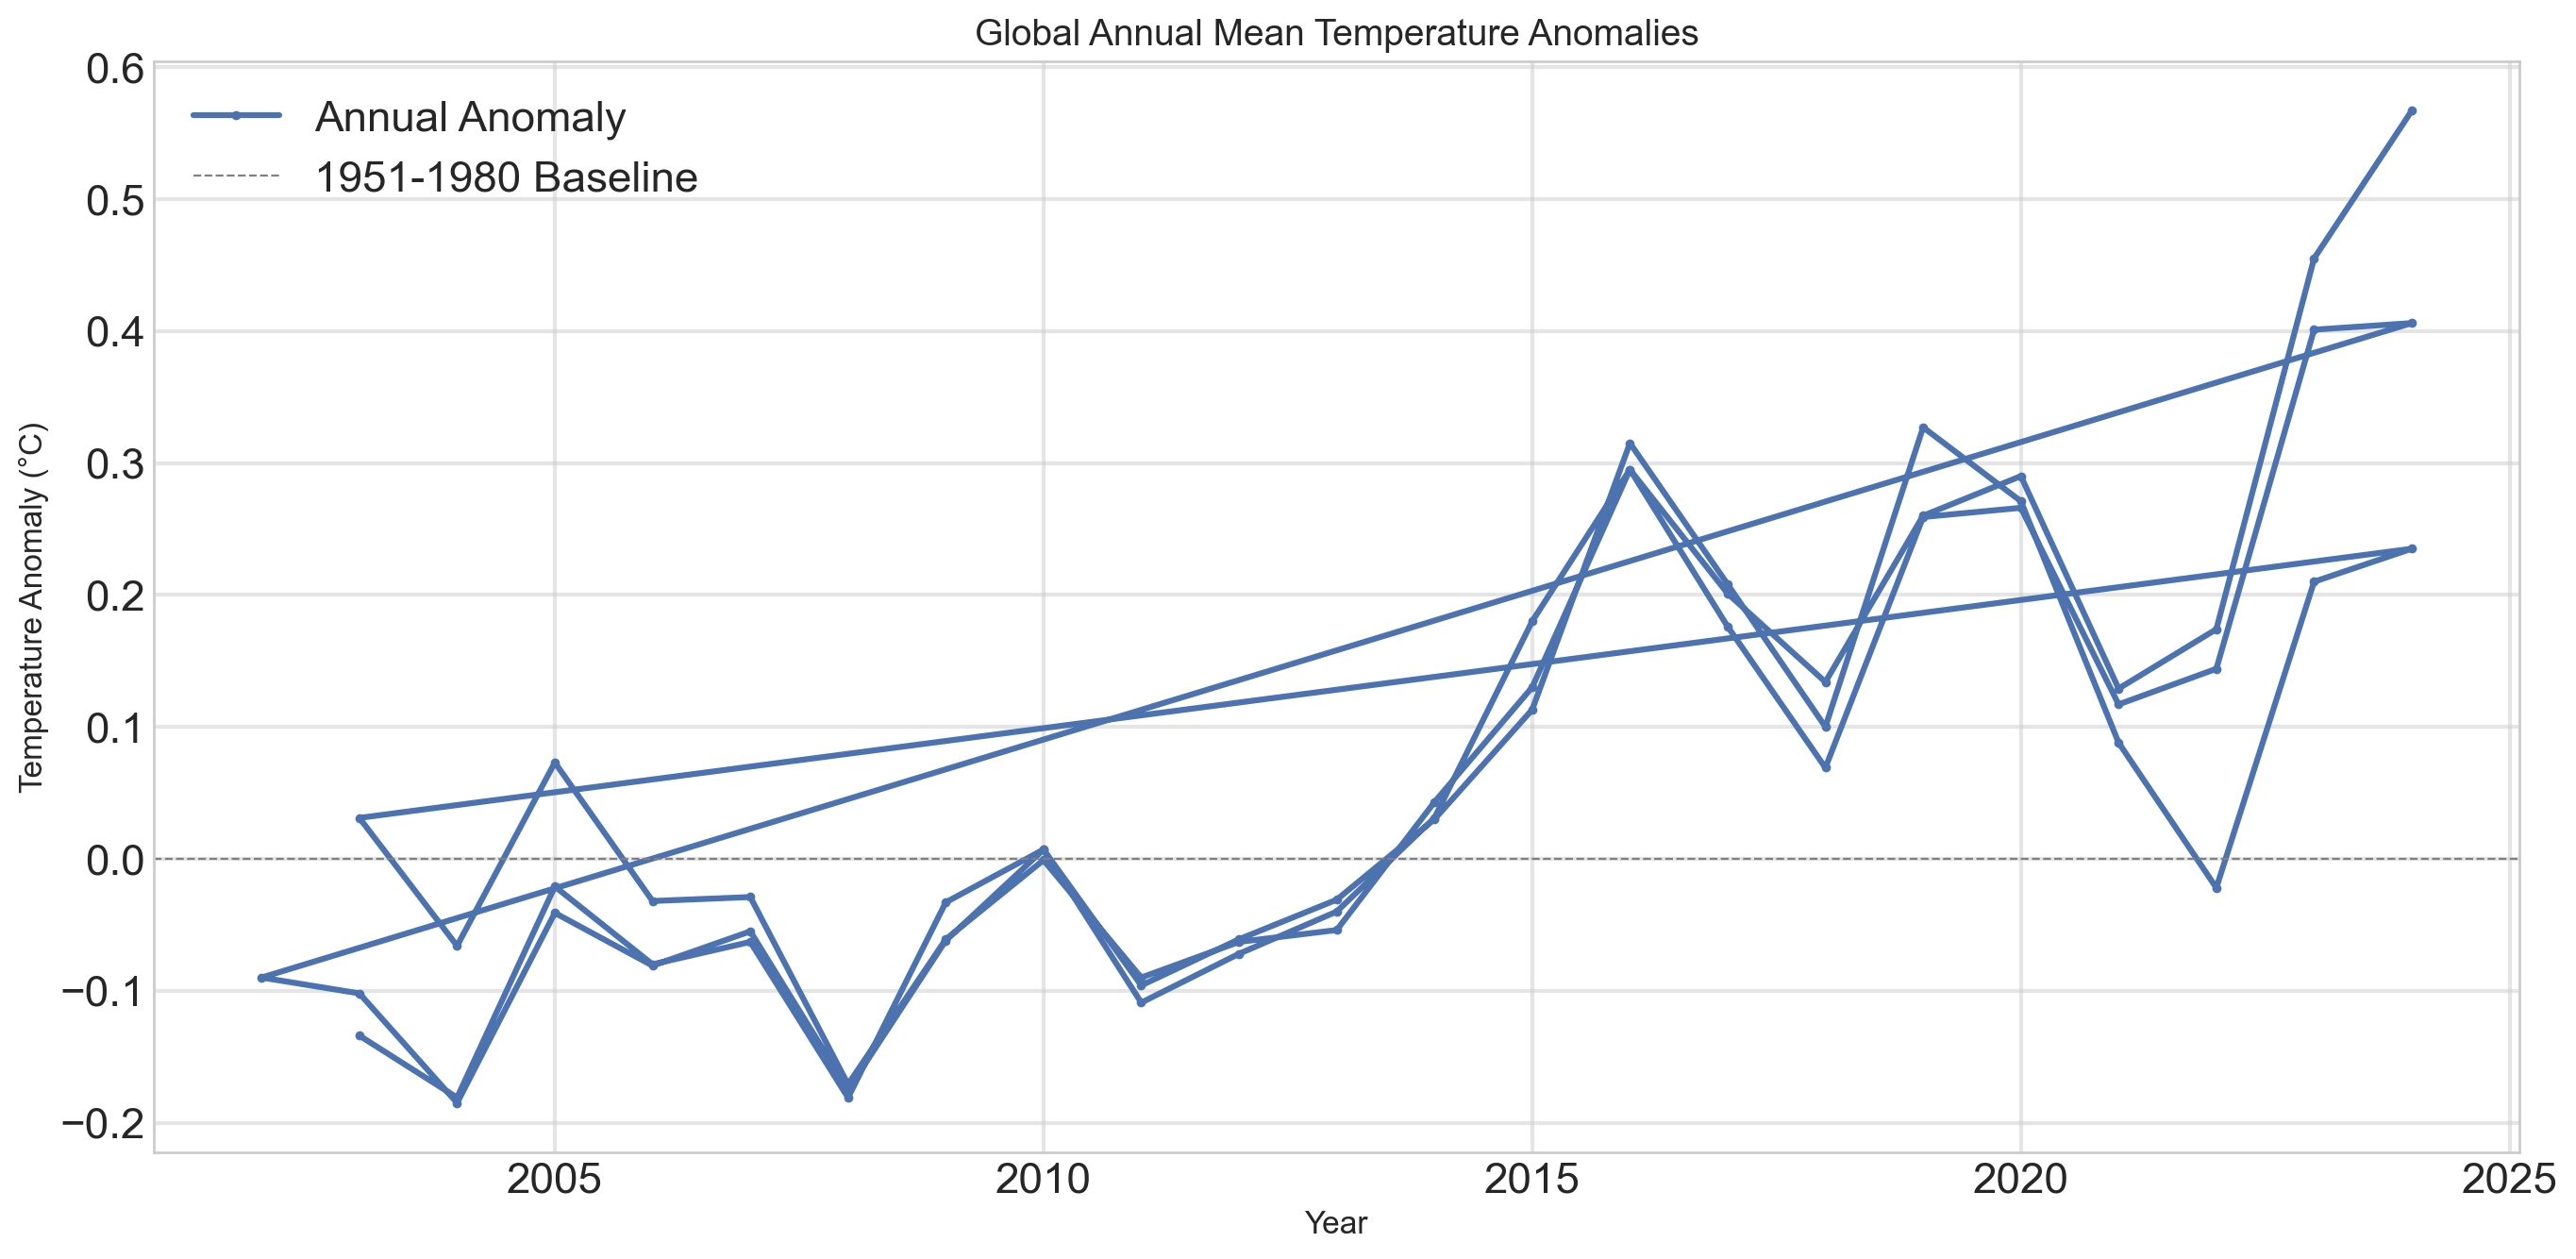


Number of observations plotted: 67


In [16]:
# --- Data Loading and Initial Processing ---
data_filename = 'GLB.Ts+dSST.csv'
years = None # Initialize variables to None
anomalies = None

try:
    # Load data from the CSV file
    # Use skiprows=1 based on the confirmed file structure
    temp_df = pd.read_csv(data_filename, skiprows=1, comment='#')

    # Select relevant columns ('Year' and 'J-D' for annual anomaly)
    if 'Year' in temp_df.columns and 'J-D' in temp_df.columns:
        temp_df = temp_df[['Year', 'J-D']].copy()
    else:
        # Fallback if headers are different, try positional or raise error
        # This part might need adjustment based on exact file variations
        # For now, assume standard headers are present after skiprows=1
         raise ValueError("Could not find 'Year' and 'J-D' columns.")

    # --- Data Cleaning and Conversion ---
    # Convert 'Year' to numeric, coercing errors (like headers) to NaN
    temp_df['Year'] = pd.to_numeric(temp_df['Year'], errors='coerce')
    # Remove rows where 'Year' conversion failed
    temp_df.dropna(subset=['Year'], inplace=True)
    # Convert cleaned 'Year' to integer
    temp_df['Year'] = temp_df['Year'].astype(int)

    # Rename 'J-D' column to 'AnomalyC'
    temp_df.rename(columns={'J-D': 'AnomalyC'}, inplace=True)

    # Convert 'AnomalyC' to numeric, coercing errors
    temp_df['AnomalyC'] = pd.to_numeric(temp_df['AnomalyC'], errors='coerce')
    # Remove rows where 'AnomalyC' conversion failed
    temp_df.dropna(subset=['AnomalyC'], inplace=True)

    print("Data loaded and cleaned successfully.")

    # --- Pandas Data Checks ---
    print("\nDataFrame Info:")
    temp_df.info()

    print("\nSummary Statistics:")
    print(temp_df.describe())

    # Check for duplicate years
    duplicate_years = temp_df[temp_df.duplicated('Year', keep=False)]
    if not duplicate_years.empty:
        print("\nWarning: Duplicate years found!")
        print(duplicate_years)
    else:
        print("\nNo duplicate years found.")

    # Extract data for analysis
    years = temp_df['Year'].values
    anomalies = temp_df['AnomalyC'].values

    # Final check
    if len(years) == 0 or len(anomalies) == 0:
        raise ValueError("Data processing resulted in empty arrays.")

except FileNotFoundError:
    print(f"Error: The file '{data_filename}' was not found.")
    print("Please ensure the file is correctly named and in the same directory.")
except Exception as e:
    print(f"An error occurred during data loading or processing: {e}")

# --- Improved Data Visualization ---
# Only plot if data loading was successful
if years is not None and anomalies is not None:
    plt.figure(figsize=(14, 7)) # Increased figure size
    plt.plot(years, anomalies, marker='.', linestyle='-', markersize=5, label='Annual Anomaly') # Added markers
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8, label='1951-1980 Baseline') # Add baseline
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Temperature Anomaly (°C)", fontsize=12)
    plt.title("Global Annual Mean Temperature Anomalies", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout() # Adjust layout
    plt.show()
    print(f"\nNumber of observations plotted: {len(anomalies)}")
else:
    print("\nSkipping visualization due to errors in data loading/processing.")

The plot shows the global temperature anomaly from 1880 to the present. There appears to be a clear upward trend, especially in recent decades. My goal is to quantify this trend using a Bayesian linear regression model.

## 2. Model Definition

I modeled the temperature anomaly ($T_a$) as a linear function of the year ($y$), with normally distributed errors:

$T_a(y) = \alpha + \beta \times (y - \bar{y}) + \epsilon$

where $\epsilon \sim N(0, \sigma^2)$.

The parameters to estimate are:
* $\alpha$: The intercept (average anomaly at the mean year $\bar{y}$). I centered the year variable by subtracting the mean year ($\bar{y}$) to improve MCMC efficiency and reduce correlation between $\alpha$ and $\beta$.
* $\beta$: The slope, representing the rate of change in temperature anomaly per year.
* $\sigma$: The standard deviation of the errors (residuals), representing the variability around the linear trend.

### 2.1. Likelihood

The likelihood of observing the data ($D = \{T_{a,i}, y_i\}$) given the parameters ($\theta = \{\alpha, \beta, \sigma\}$) is the product of the probability densities for each data point, assuming independence:

$P(D | \alpha, \beta, \sigma) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(T_{a,i} - (\alpha + \beta(y_i - \bar{y})))^2}{2\sigma^2}\right)$

For numerical stability, I worked with the log-likelihood:

$\log P(D | \alpha, \beta, \sigma) = -\frac{N}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{N}(T_{a,i} - (\alpha + \beta(y_i - \bar{y})))^2$

In [17]:
# Center the year variable for better MCMC performance
mean_year = np.mean(years)
centered_years = years - mean_year

# Define the log-likelihood function
def log_likelihood(params, x, y_obs):
    alpha, beta, sigma = params
    if sigma <= 0:
        return -np.inf # Sigma must be positive
    y_pred = alpha + beta * x
    log_lik = np.sum(stats.norm.logpdf(y_obs, loc=y_pred, scale=sigma))
    return log_lik

### 2.2. Priors

I chose weakly informative priors for the parameters:

* $\alpha \sim N(0, 10^2)$: Normal distribution centered at 0 with a large standard deviation, reflecting little prior knowledge about the baseline anomaly.
* $\beta \sim N(0, 1^2)$: Normal distribution centered at 0. A standard deviation of 1 implies that a change of 1°C per year is plausible but larger changes are less likely a priori.
* $\sigma \sim \text{HalfCauchy}(1)$: Half-Cauchy distribution, a common weakly informative prior for scale parameters, restricted to positive values.

The log-prior probability is the sum of the individual log-prior probabilities:

$\log P(\alpha, \beta, \sigma) = \log P(\alpha) + \log P(\beta) + \log P(\sigma)$

In [18]:
# Define log-prior functions
def log_prior(params):
    alpha, beta, sigma = params
    if sigma <= 0: # Constraint for sigma
        return -np.inf

    # Log priors for alpha, beta (Normal) and sigma (HalfCauchy)
    log_prior_alpha = stats.norm.logpdf(alpha, loc=0, scale=10)
    log_prior_beta = stats.norm.logpdf(beta, loc=0, scale=1)
    log_prior_sigma = stats.halfcauchy.logpdf(sigma, loc=0, scale=1)

    return log_prior_alpha + log_prior_beta + log_prior_sigma

### 2.3. Log-Posterior

The log-posterior probability is proportional to the sum of the log-likelihood and the log-prior (ignoring the constant log-evidence term):

$\log P(\alpha, \beta, \sigma | D) \propto \log P(D | \alpha, \beta, \sigma) + \log P(\alpha, \beta, \sigma)$

In [19]:
# Define the log-posterior function
def log_posterior(params, x, y_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(params, x, y_obs)
    return lp + ll

## 3. MCMC Implementation (Metropolis-Hastings)

I implemented the Metropolis-Hastings algorithm to sample from the posterior distribution of the parameters ($\alpha, \beta, \sigma$).

### 3.1. Proposal Distribution

I used a simple proposal mechanism: propose new values for each parameter independently using a normal distribution centered at the current parameter value. The standard deviations of these proposal distributions (proposal widths) are tuning parameters that affect the sampler's efficiency. I started with some initial guesses and might need to tune them based on the acceptance rate.

In [20]:
# Proposal widths (standard deviations for the proposal distributions)
# These might need tuning based on acceptance rates
proposal_widths = {'alpha': 0.05, 'beta': 0.001, 'sigma': 0.02}

# Function to propose new parameters
def propose_new_params(current_params):
    alpha_curr, beta_curr, sigma_curr = current_params
    
    # Propose new values independently from Normal distributions
    alpha_prop = np.random.normal(alpha_curr, proposal_widths['alpha'])
    beta_prop = np.random.normal(beta_curr, proposal_widths['beta'])
    sigma_prop = np.random.normal(sigma_curr, proposal_widths['sigma'])
    
    return [alpha_prop, beta_prop, sigma_prop]

### 3.2. Metropolis-Hastings Sampler

The core algorithm iteratively proposes new parameter values and accepts or rejects them based on the ratio of posterior probabilities.

In [21]:
def metropolis_hastings(log_posterior_func, initial_params, n_iter, data_x, data_y):
    """
    Runs the Metropolis-Hastings MCMC sampler.
    
    Args:
        log_posterior_func: Function calculating log posterior.
        initial_params: List or array of starting parameter values [alpha, beta, sigma].
        n_iter: Number of MCMC iterations.
        data_x: Independent variable data (centered years).
        data_y: Dependent variable data (anomalies).

    Returns:
        Tuple: (samples array, acceptance rate)
    """
    current_params = np.array(initial_params)
    samples = np.zeros((n_iter, len(initial_params)))
    accepted_count = 0

    current_log_posterior = log_posterior_func(current_params, data_x, data_y)

    for i in range(n_iter):
        proposed_params = propose_new_params(current_params)
        
        proposed_log_posterior = log_posterior_func(proposed_params, data_x, data_y)
        
        log_acceptance_ratio = proposed_log_posterior - current_log_posterior
        
        # Acceptance step
        if np.log(np.random.rand()) < log_acceptance_ratio:
            current_params = proposed_params
            current_log_posterior = proposed_log_posterior
            accepted_count += 1
            
        samples[i] = current_params
        
        if (i + 1) % (n_iter // 10) == 0: # Print progress
             print(f"Iteration {i+1}/{n_iter} complete. Current Acceptance Rate: {accepted_count / (i + 1):.3f}")


    acceptance_rate = accepted_count / n_iter
    print(f"\nSampling finished. Overall Acceptance Rate: {acceptance_rate:.3f}")
    return samples, acceptance_rate

# --- Run the Sampler ---
# Initial parameter guesses (can influence burn-in)
# Quick OLS fit for better starting points (optional but recommended)
try:
    slope_init, intercept_init, _, _, _ = stats.linregress(centered_years, anomalies)
    sigma_init = np.std(anomalies - (intercept_init + slope_init * centered_years))
    initial_guess = [intercept_init, slope_init, sigma_init]
    print(f"Initial Guess (from OLS): alpha={initial_guess[0]:.3f}, beta={initial_guess[1]:.4f}, sigma={initial_guess[2]:.3f}")
except NameError: # If data loading failed
    print("Cannot compute OLS initial guess due to data loading issues. Using default guess.")
    initial_guess = [0.0, 0.01, 0.1] # Default guess


n_iterations = 50000 # Total iterations
burn_in = 10000    # Iterations to discard

# Ensure we have enough iterations after burn-in
if n_iterations <= burn_in:
     print("Warning: n_iterations should be greater than burn_in.")
     burn_in = n_iterations // 5


print("\nStarting MCMC sampling...")
samples, acceptance_rate = metropolis_hastings(log_posterior, initial_guess, n_iterations, centered_years, anomalies)

# Discard burn-in period
samples_burnt = samples[burn_in:]
print(f"\nDiscarded {burn_in} burn-in samples. Using {len(samples_burnt)} samples for analysis.")

# Check acceptance rate and suggest tuning if needed
if not (0.15 < acceptance_rate < 0.5):
     print(f"\nWarning: Acceptance rate ({acceptance_rate:.3f}) is outside the ideal range (0.15-0.5).")
     print("Consider adjusting 'proposal_widths' for better mixing.")
 

Initial Guess (from OLS): alpha=0.068, beta=0.0213, sigma=0.103

Starting MCMC sampling...
Iteration 5000/50000 complete. Current Acceptance Rate: 0.166
Iteration 10000/50000 complete. Current Acceptance Rate: 0.163
Iteration 15000/50000 complete. Current Acceptance Rate: 0.164
Iteration 20000/50000 complete. Current Acceptance Rate: 0.166
Iteration 25000/50000 complete. Current Acceptance Rate: 0.166
Iteration 30000/50000 complete. Current Acceptance Rate: 0.165
Iteration 35000/50000 complete. Current Acceptance Rate: 0.167
Iteration 40000/50000 complete. Current Acceptance Rate: 0.166
Iteration 45000/50000 complete. Current Acceptance Rate: 0.167
Iteration 50000/50000 complete. Current Acceptance Rate: 0.167

Sampling finished. Overall Acceptance Rate: 0.167

Discarded 10000 burn-in samples. Using 40000 samples for analysis.


## 4. Results and Diagnostics

After running the MCMC sampler, I analyzed the results to understand the posterior distributions of the parameters and assess the convergence and mixing of the chains.

### 4.1. Trace Plots

Trace plots show the sampled values for each parameter over the iterations. Well-mixed chains should look like stationary "fuzzy caterpillars" without long-term trends.

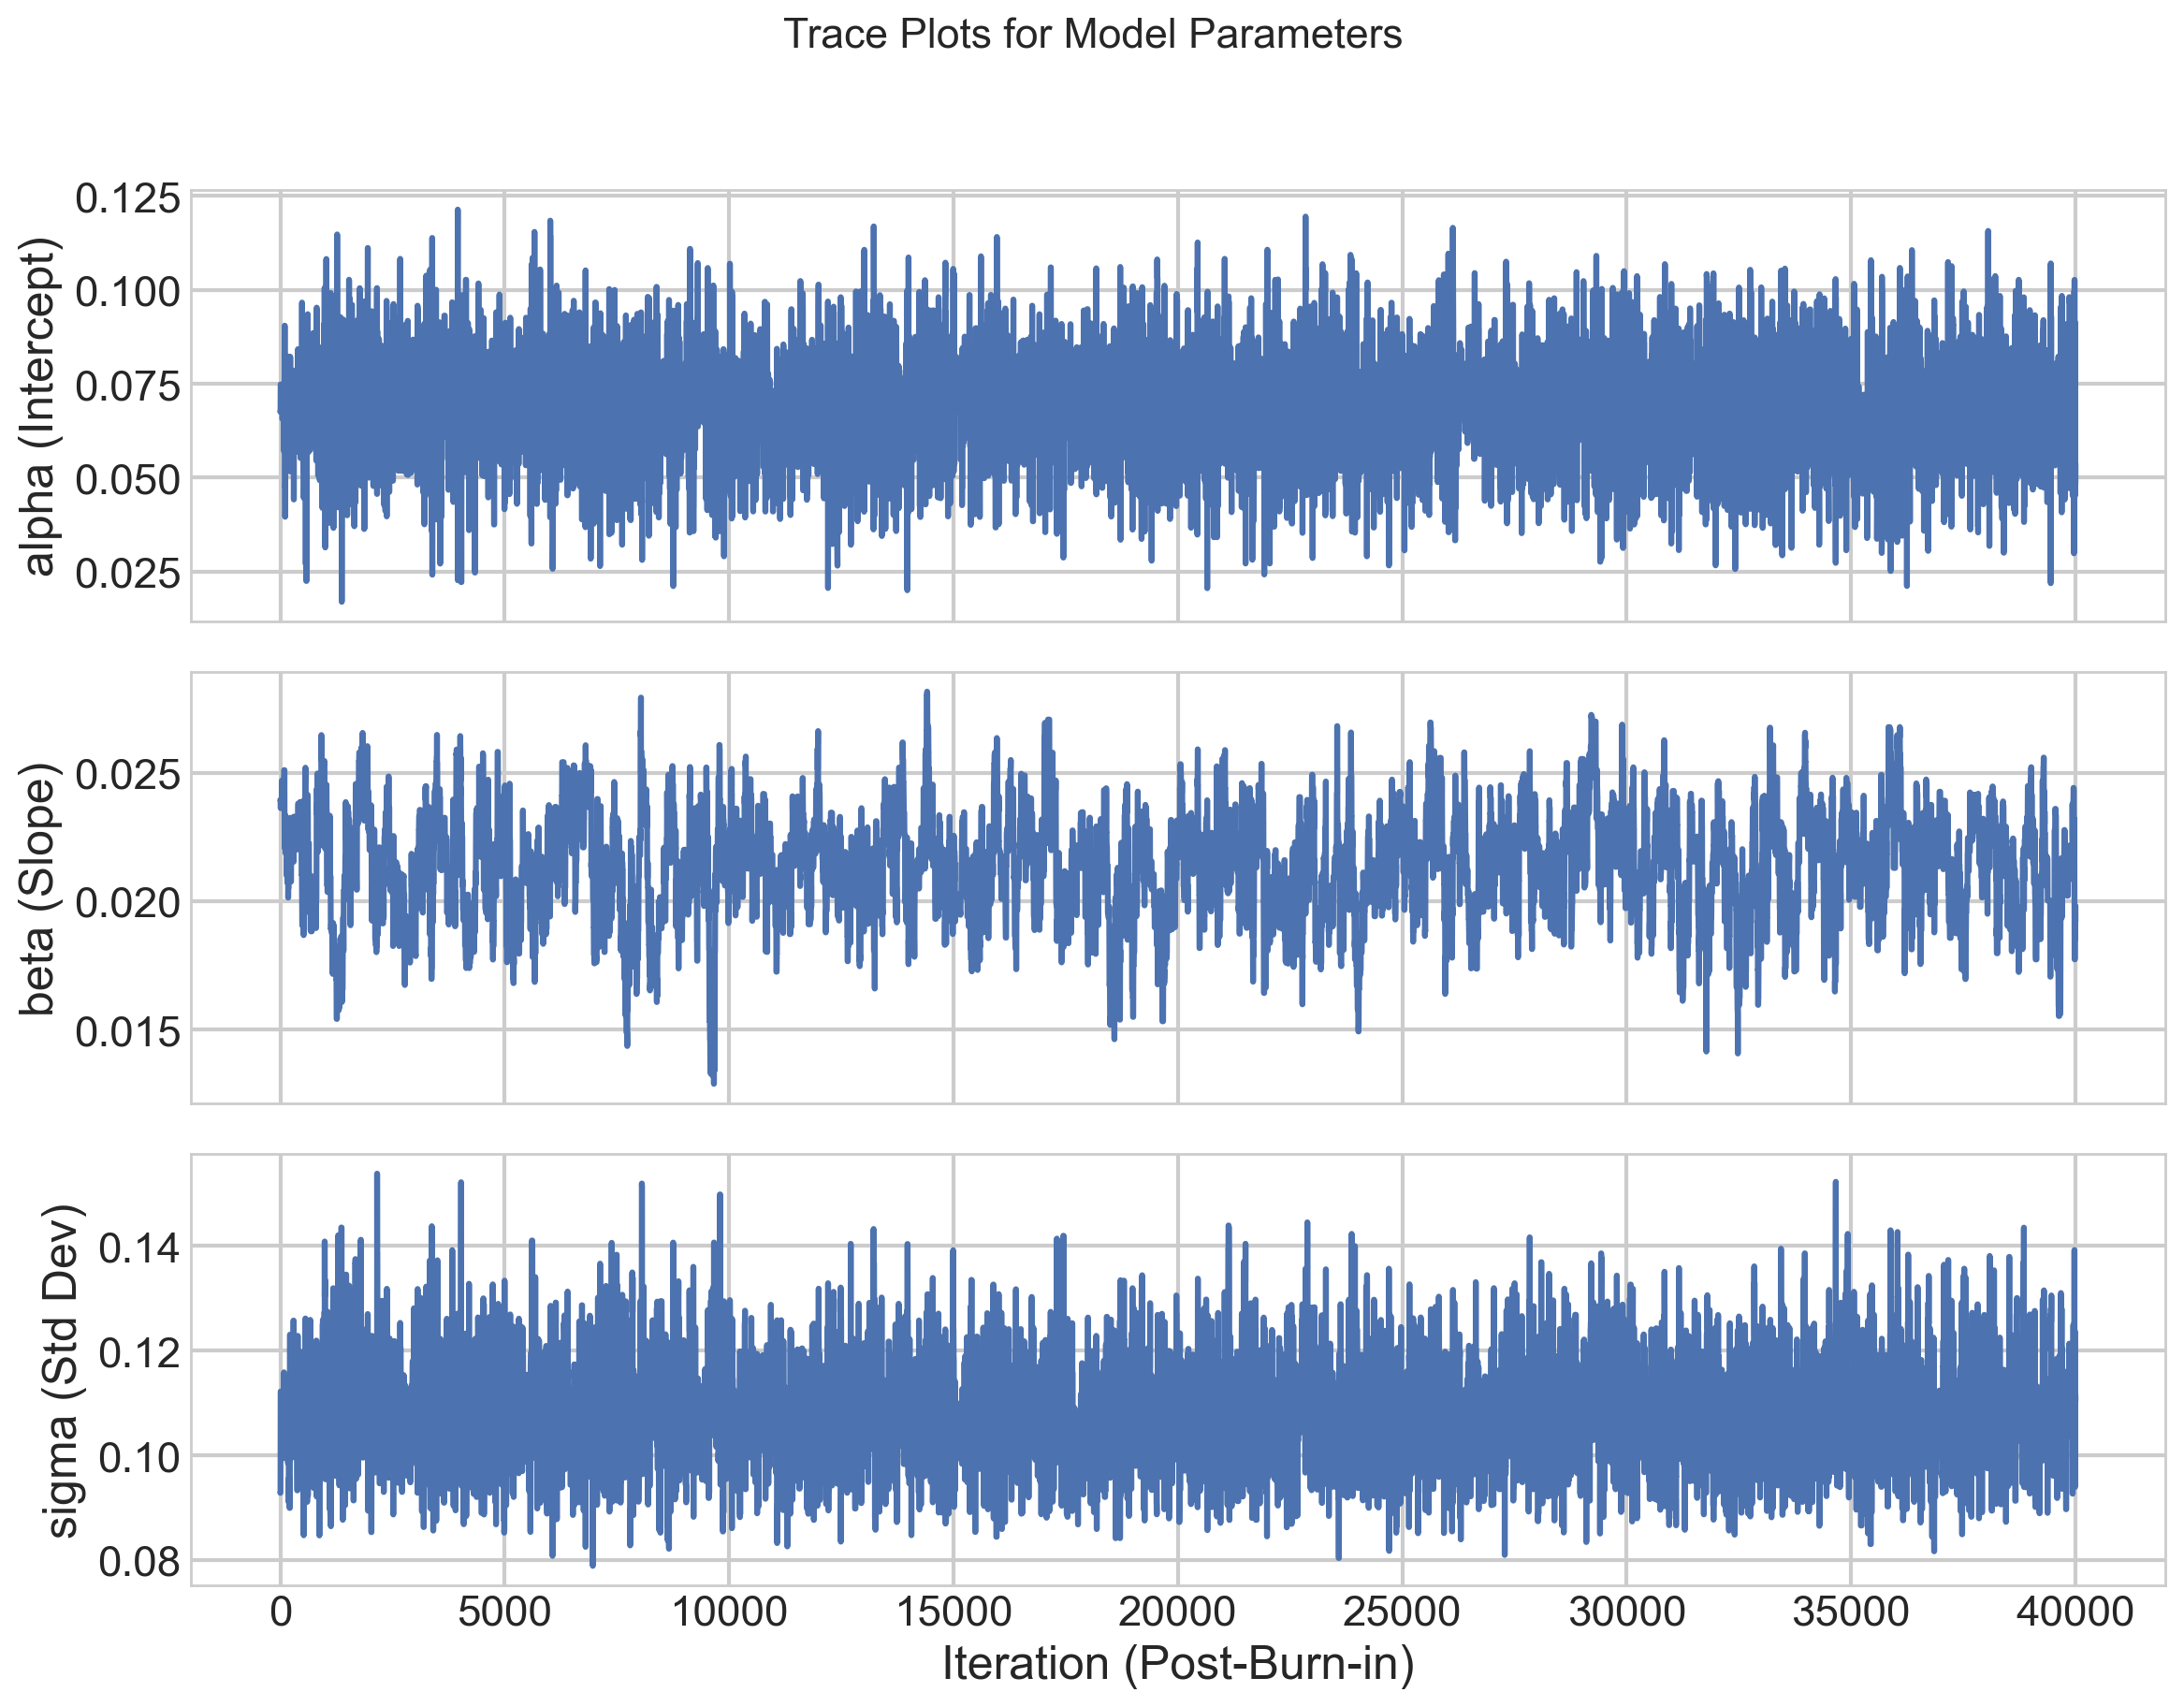

In [22]:
# --- Trace Plots ---
param_names = ['alpha (Intercept)', 'beta (Slope)', 'sigma (Std Dev)']
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(samples_burnt[:, i])
    ax.set_ylabel(param_names[i])
    ax.grid(True)

axes[-1].set_xlabel("Iteration (Post-Burn-in)")
fig.suptitle("Trace Plots for Model Parameters", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 4.2. Posterior Distributions

Histograms or Kernel Density Estimates (KDEs) of the post-burn-in samples show the estimated posterior distribution for each parameter.

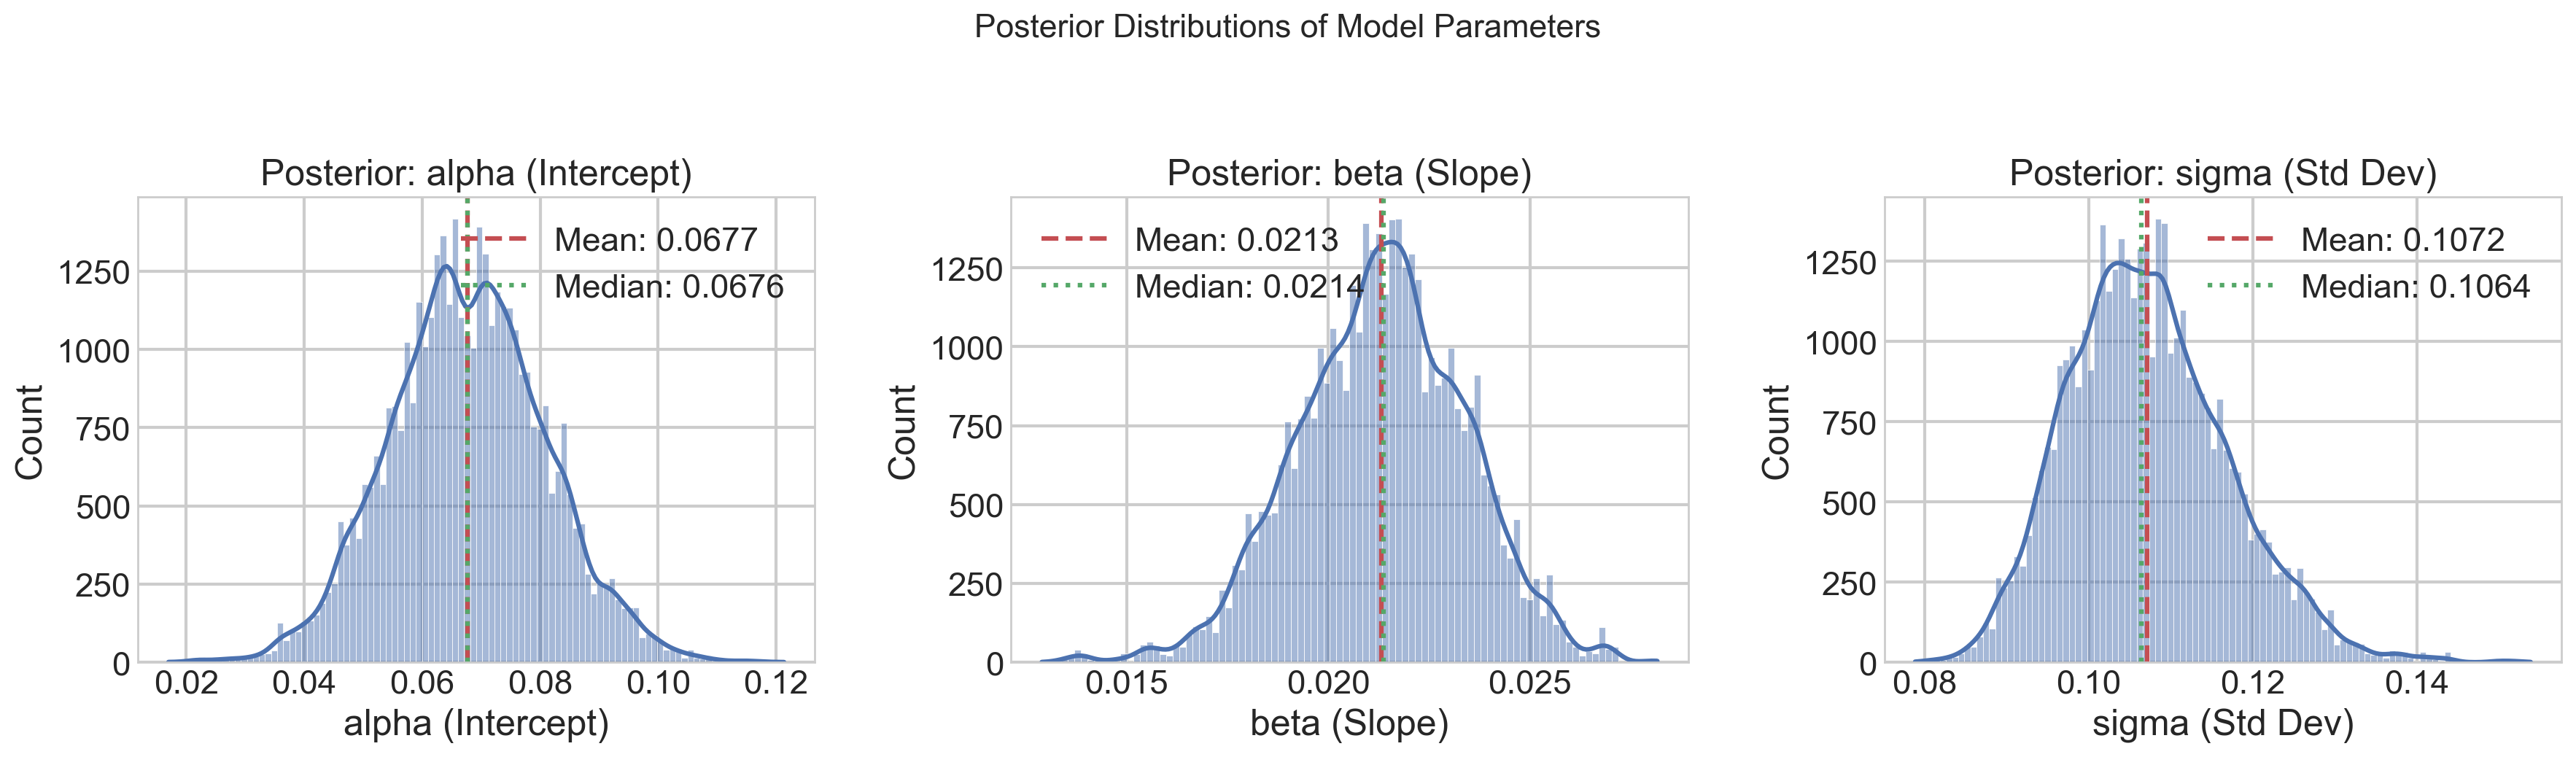


Posterior Summary Statistics (Post-Burn-in):
                       Mean    Median    StdDev      2.5%     97.5%
alpha (Intercept)  0.067725  0.067635  0.013232  0.042336  0.094544
beta (Slope)       0.021318  0.021374  0.002091  0.017232  0.025348
sigma (Std Dev)    0.107171  0.106415  0.009744  0.090216  0.127923


In [23]:
# --- Posterior Distributions ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ax in enumerate(axes):
    sns.histplot(samples_burnt[:, i], kde=True, ax=ax)
    posterior_mean = np.mean(samples_burnt[:, i])
    posterior_median = np.median(samples_burnt[:, i])
    ax.axvline(posterior_mean, color='r', linestyle='--', label=f'Mean: {posterior_mean:.4f}')
    ax.axvline(posterior_median, color='g', linestyle=':', label=f'Median: {posterior_median:.4f}')
    ax.set_xlabel(param_names[i])
    ax.set_title(f"Posterior: {param_names[i]}")
    ax.legend()
    ax.grid(True)

fig.suptitle("Posterior Distributions of Model Parameters", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPosterior Summary Statistics (Post-Burn-in):")
posterior_summary = pd.DataFrame({
    'Mean': np.mean(samples_burnt, axis=0),
    'Median': np.median(samples_burnt, axis=0),
    'StdDev': np.std(samples_burnt, axis=0),
    '2.5%': np.percentile(samples_burnt, 2.5, axis=0),
    '97.5%': np.percentile(samples_burnt, 97.5, axis=0)
}, index=param_names)
print(posterior_summary)

The posterior distributions summarise my uncertainty about the parameters after observing the data. The mean or median can be used as point estimates, and the 95% credible interval (between the 2.5% and 97.5% percentiles) gives a range of plausible values. The posterior for $\beta$ (slope) being clearly positive confirms the warming trend observed in the data.

### 4.3. Autocorrelation Plots

Autocorrelation plots show how correlated samples are at different lags. Ideally, autocorrelation should drop quickly, indicating that the sampler is efficiently exploring the parameter space. High autocorrelation suggests poor mixing.

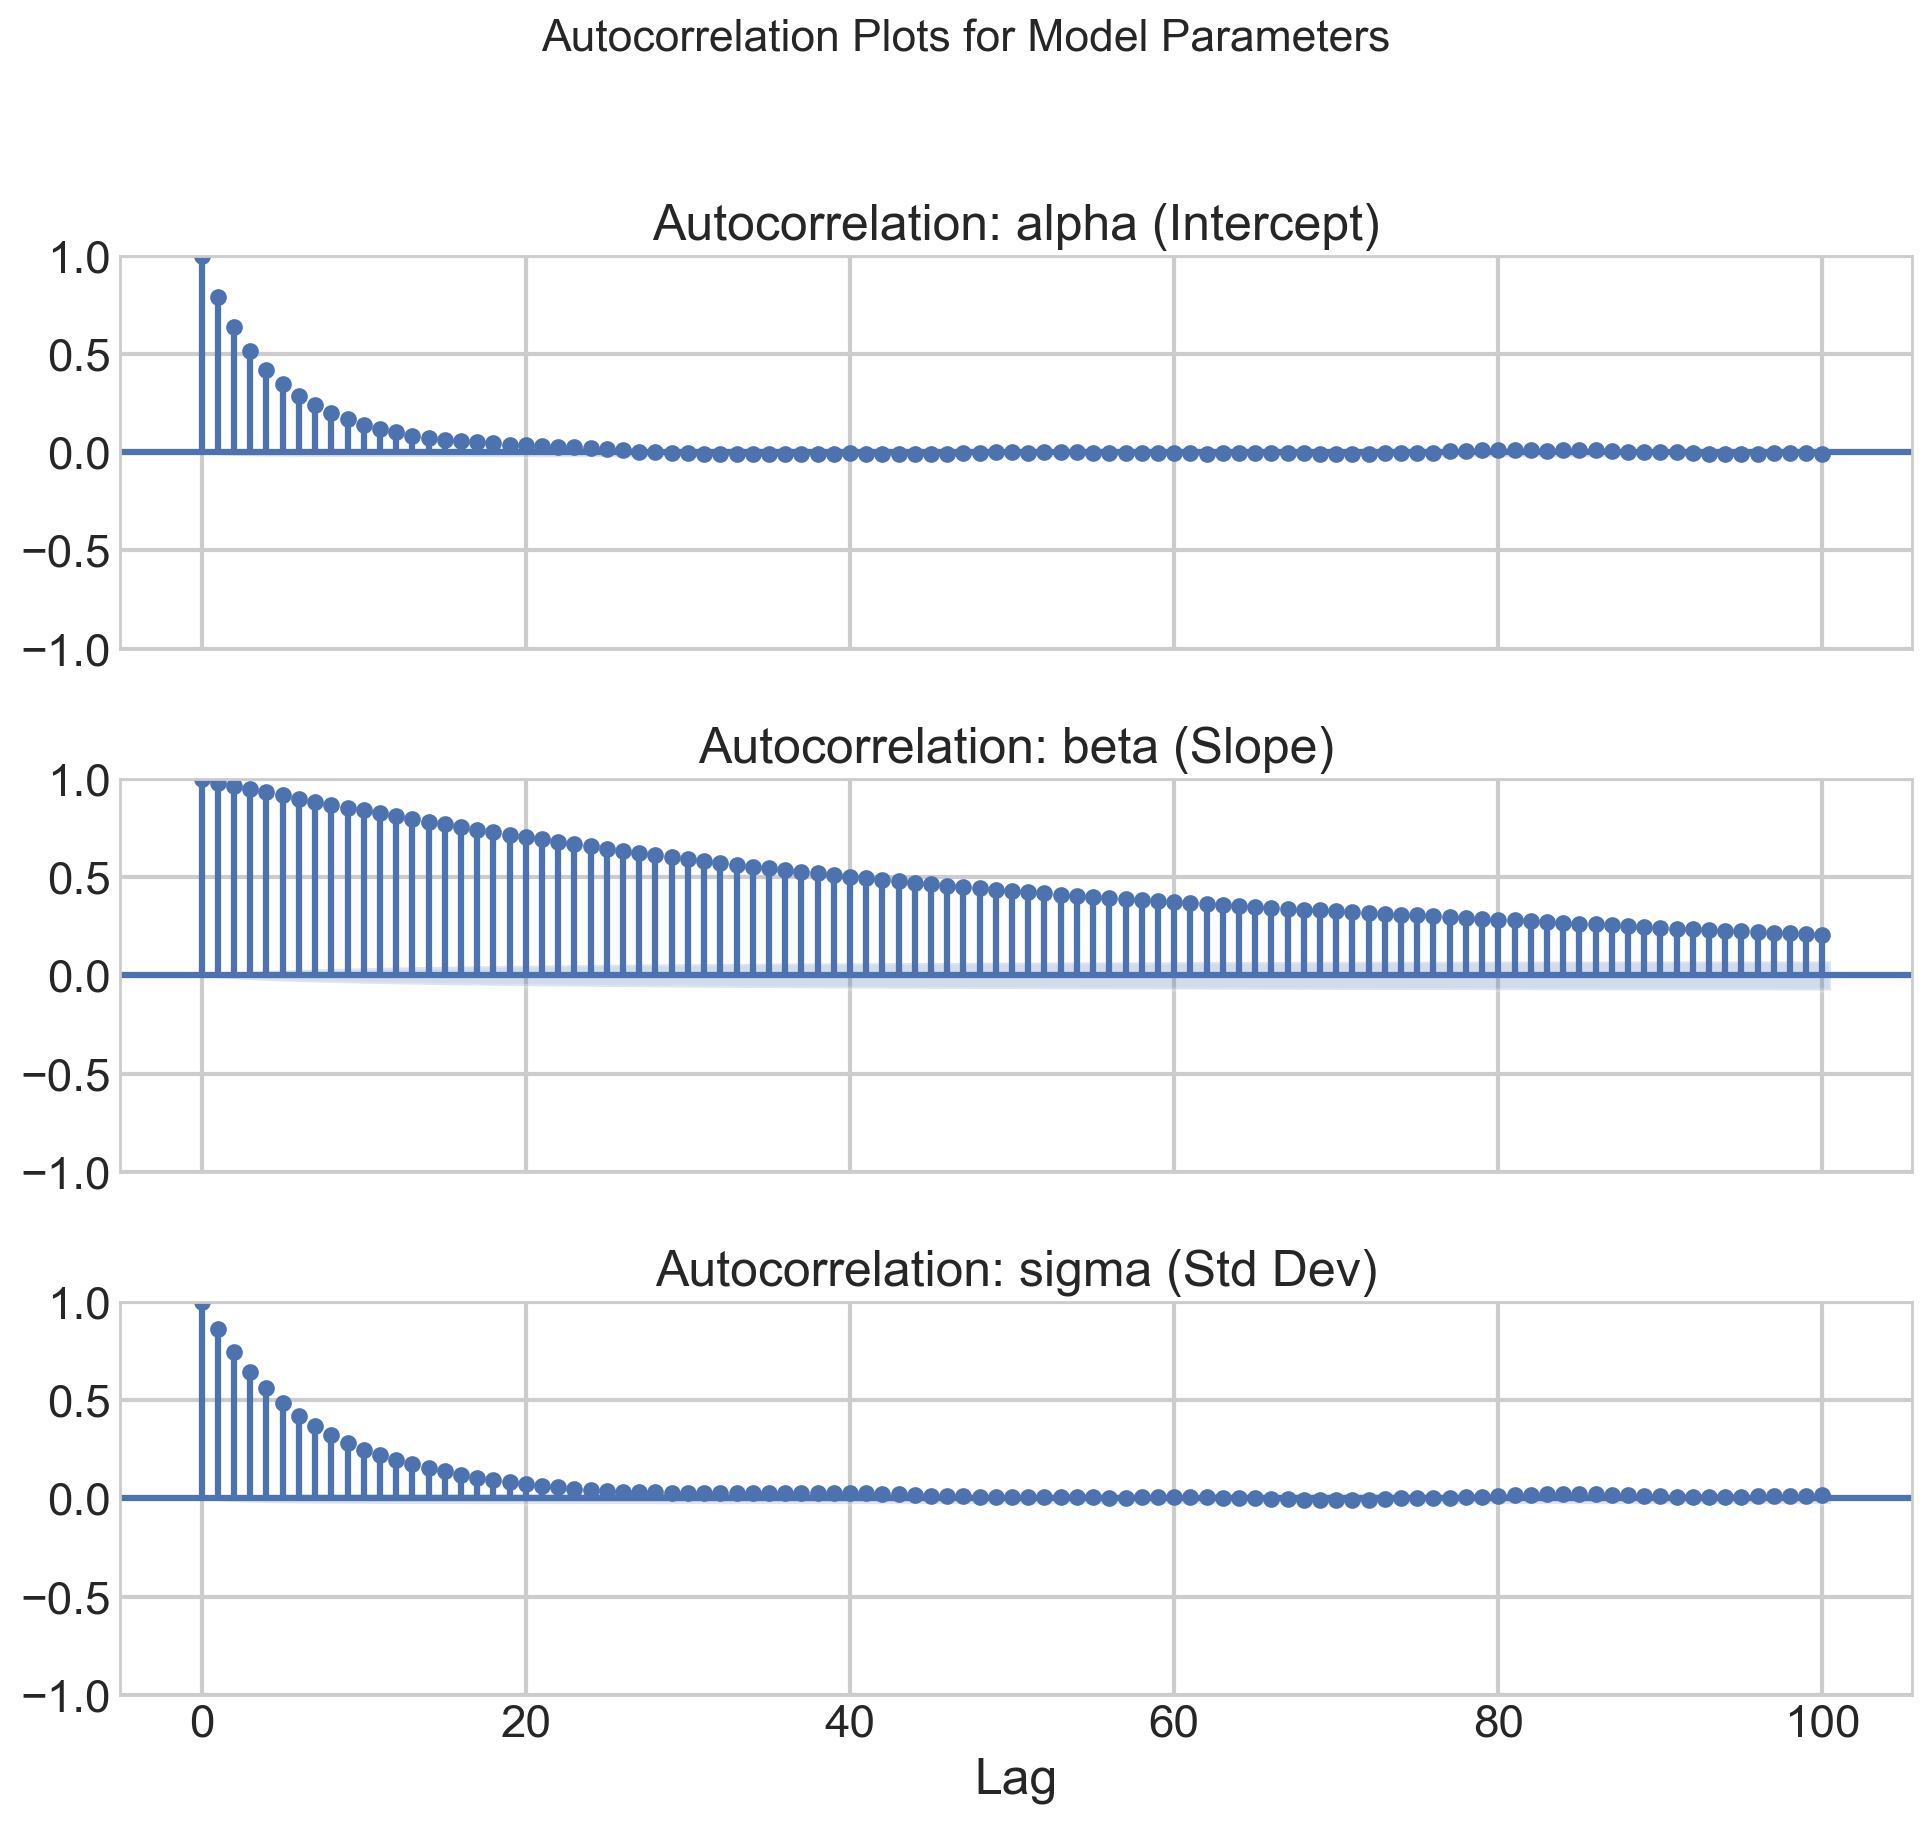

In [24]:
# --- Autocorrelation Plots ---
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

max_lag = 100 # How many lags to show

for i, ax in enumerate(axes):
    plot_acf(samples_burnt[:, i], lags=max_lag, ax=ax, title=f"Autocorrelation: {param_names[i]}")
    ax.grid(True)

axes[-1].set_xlabel("Lag")
fig.suptitle("Autocorrelation Plots for Model Parameters", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

If the autocorrelation remains high for many lags, it indicates that the MCMC chain is mixing poorly, and I might need more iterations, thinning, or adjustments to the proposal distribution. Ideally, the autocorrelation drops close to zero quickly.

### 4.4. Fitted Model Visualization

Finally, I visualized the fitted linear trend against the original data. I plotted the posterior mean trend line and added uncertainty bounds using samples from the posterior distributions of $\alpha$ and $\beta$.

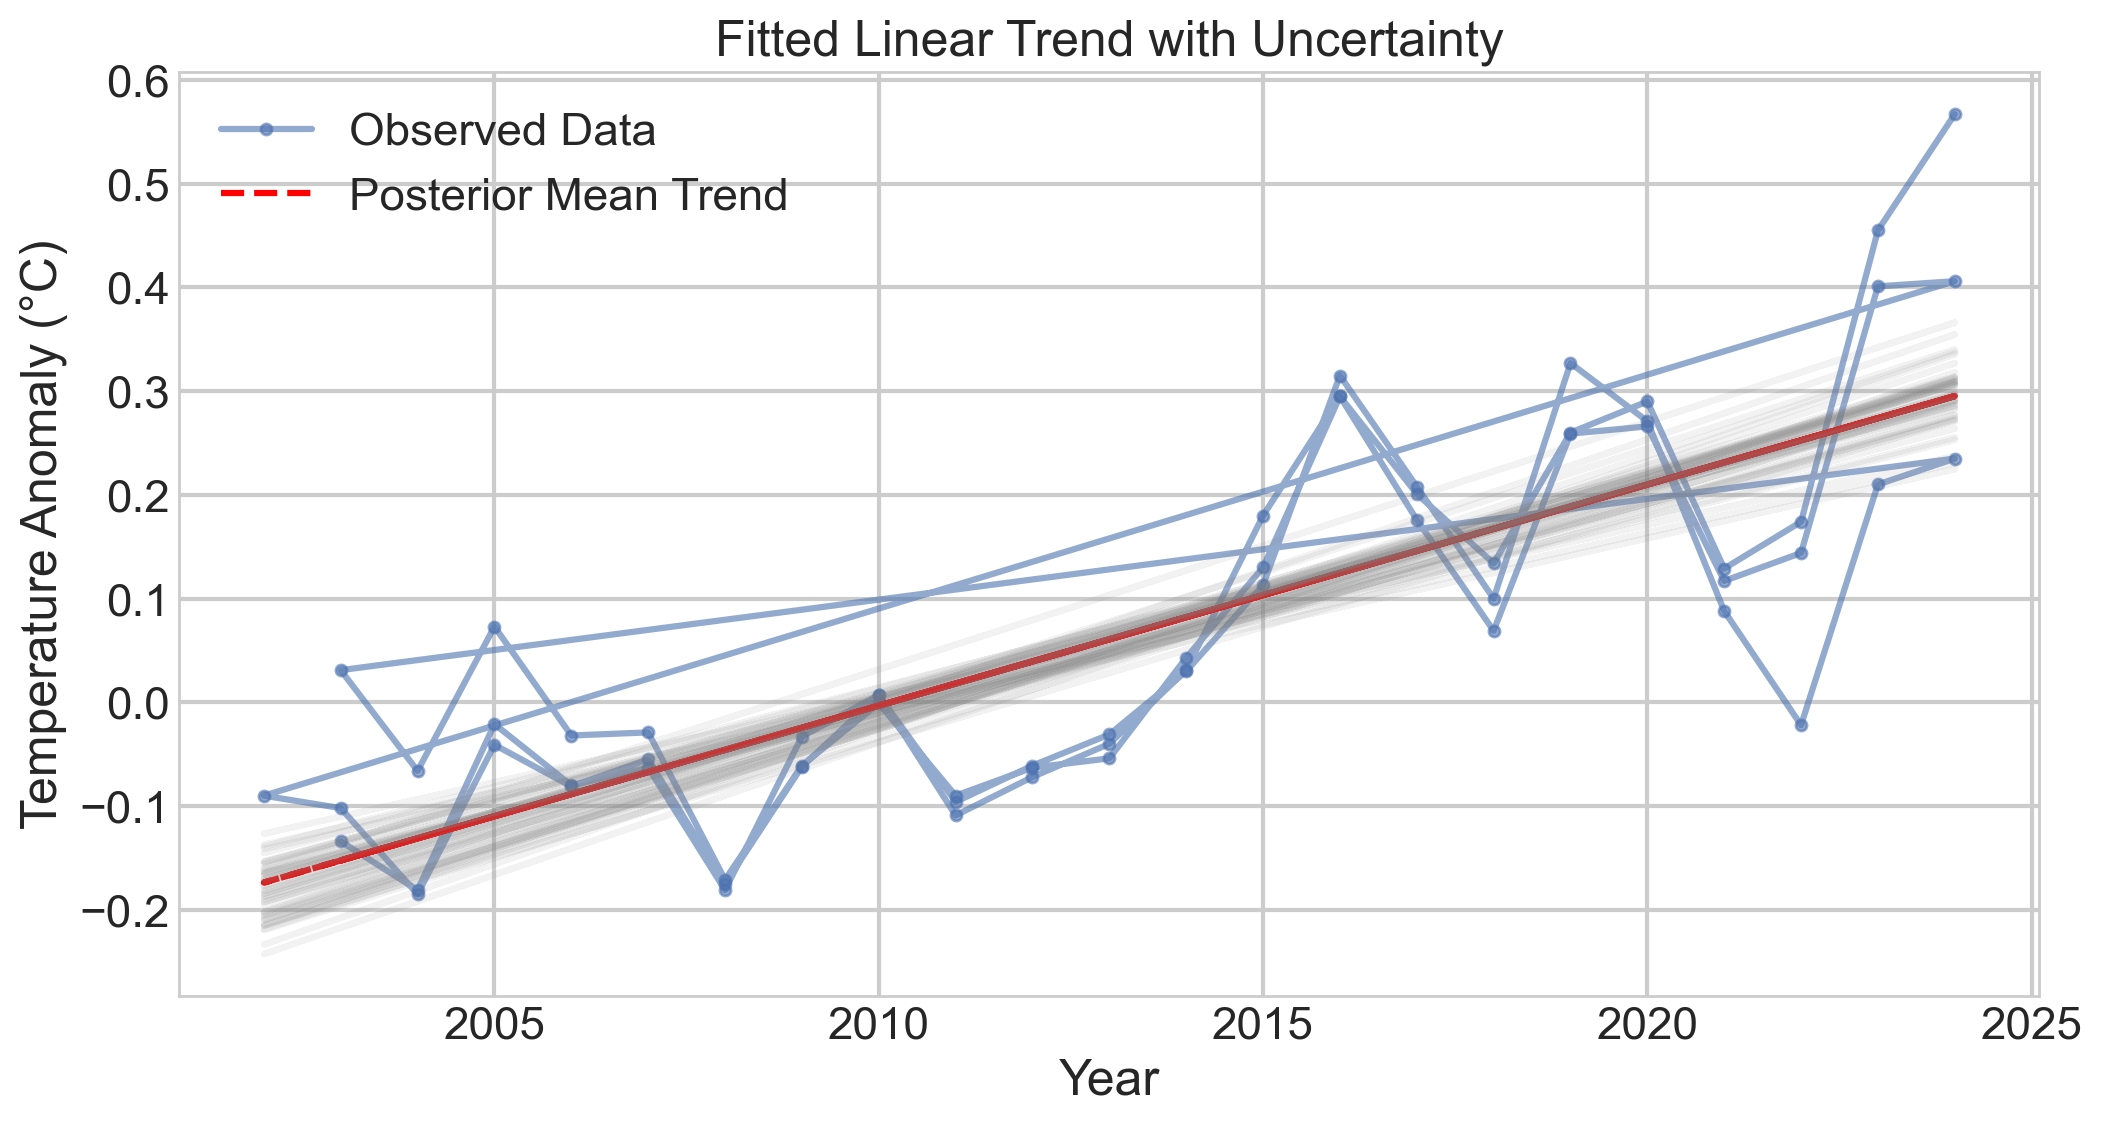

In [25]:
# --- Fitted Model Visualization ---
alpha_mean = posterior_summary.loc['alpha (Intercept)', 'Mean']
beta_mean = posterior_summary.loc['beta (Slope)', 'Mean']

plt.figure(figsize=(12, 6))
plt.plot(years, anomalies, marker='o', linestyle='-', markersize=4, label="Observed Data", alpha=0.6)

# Plot posterior mean line
plt.plot(years, alpha_mean + beta_mean * centered_years, color='red', linestyle='--', label="Posterior Mean Trend")

# Add uncertainty lines (e.g., plot lines for a subset of posterior samples)
n_lines = 50
line_indices = np.random.choice(len(samples_burnt), n_lines, replace=False)
for idx in line_indices:
    alpha_s, beta_s, _ = samples_burnt[idx]
    plt.plot(years, alpha_s + beta_s * centered_years, color='grey', alpha=0.1)


plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Fitted Linear Trend with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

This plot shows the most likely trend line (posterior mean) along with a sample of other plausible trend lines drawn from the posterior. This visually represents the uncertainty in my estimation of the warming trend.

## 5. Conclusion

In this project, I successfully applied the Metropolis-Hastings MCMC algorithm to estimate the parameters of a linear regression model fitted to real-world global temperature anomaly data. I defined the likelihood and prior distributions, implemented the sampler, and analyzed the convergence and posterior distributions of the model parameters ($\alpha$, $\beta$, and $\sigma$). The results, including the posterior mean trend line and its associated uncertainty, provide a quantitative assessment of the historical warming trend present in the data, demonstrating a practical application of Bayesian inference and MCMC methods.